# DH-Parametertabelle youBot

$\begin{array}{rr} \hline
\mathbf{Gelenk} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

DH Parameter

In [1]:
import sympy as sp
import numpy as np

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])

Wir programmieren nun eine Python-Funktion <b>dhIthFrame</b> zur Erstellung eines einzelnen DH-Frames. Dabei übergeben wir noch keine Parameter, sondern bleiben gänzlich auf symbolischer Ebene mit $\theta$, $d$, $a$ und $\alpha$.

In [2]:
def dhIthFrame(theta, d, a, alpha):
    
    rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
                            [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
                            [0, 0, 0, 1] ])
    
    trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
    trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
    rot_alpha = np.matrix([ [1, 0, 0, 0], 
                            [0, np.cos(alpha), -np.sin(alpha), 0], 
                            [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
    dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
    return dh_ith_frame;

Dieses DH-Frame ist unsere Blaupause für die Forwärtstransformation am youBot. Wir definieren eine Python-Funktion <b>buildDhTcpFrame</b>, in welcher wir die Argumente eines solchen Blaupause-Frames durch die DH-Parameter und den Symbolen für die Gelenkwinkel $q_{1}$ bis $q_{5}$ iterativ substituieren und die resultierenden Frames zu einem Ergebnis-Frame akkumulieren. Anschließend vereinfachen wir noch das Ergebnis mit <b>trigsimp</b>.

In [3]:
def buildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame

In [4]:
def normalize(data):
    dmax = np.radians(165)
    dmin = np.radians(-168)

    for i, arr in enumerate(data):
        for j, value in enumerate(arr):
            data[i][j] = (2 * (value - dmin) / (dmax - dmin)) - 1

In [5]:
def denormalize(data):
    dmax = np.radians(165)
    dmin = np.radians(-168)
    
    for i, arr in enumerate(data):
        for j, value in enumerate(arr):
            data[i][j] = (((value + 1) * (dmax - dmin)) / 2) + dmin

Kuka YouBot Gelenkwinkelgrenzenin Grad [+/-]

In [6]:
def generate_data(iterations=5):
    #Maximale und minimale Werte (based on robo freedom tests) */
    a1 = [165, -168]
    a2 = [85, -64]
    a3 = [145, -141]
    a4 = [101, -101]
    a5 = [155, -161]
    joint_limits = [a1, a2, a3, a4, a5]
    pos_arr = []
    for i in range(iterations):
        degree_joint_pos = []
        for joint_range in joint_limits:
            joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
            degree_joint_pos.append(joint_val)
        degree_joint_pos = np.asarray(degree_joint_pos)
        radians = np.radians(degree_joint_pos)
#         radians = degree_joint_pos
        pos_arr.append(radians)
    
    positions = np.asarray(pos_arr)
    
    tcp = []
    for i in range(iterations):
        frame = buildDhTcpFrame(positions[i])
        frame = np.asarray(frame.flatten())
        frame = frame[0:, :12]
        frame = np.squeeze(frame)
#         xyz = frame[3::4]
        tcp.append(frame)

    tcp = np.asarray(tcp)

    return positions, tcp

Generiere eine Anzahl von zufälligen Gelenkwinkelpositionen und dazugehöriges TCP Frame

In [8]:
import time

start = time.time()

joint_pos, tcp_pos = generate_data(10)
# max_tcp = np.amax(np.absolute(tcp_positions))
# tcp_positions = tcp_positions / max_tcp
end = time.time()
print(end - start)

0.016738176345825195


In [9]:
print("TCP Length:", len(tcp_pos))
print("Joint Length:", len(joint_pos))
print("TCP Shape:", tcp_pos.shape)
print("Joint Shape:", joint_pos.shape)

TCP Length: 10
Joint Length: 10
TCP Shape: (10, 12)
Joint Shape: (10, 5)


<IPython.core.display.Javascript object>


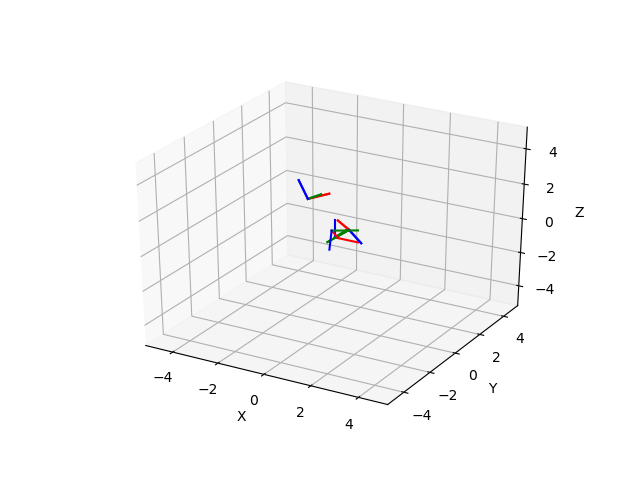

In [98]:
from mpl_toolkits import mplot3d
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import *
%matplotlib notebook

tcp = tcp_pos

ax = plot_basis(R=np.eye(3), ax_s=5)
f = 5
samples = np.random.randint(0, len(tcp), 5)
for i in samples:
    point = np.asarray([tcp[i][3] *f, tcp[i][7] *f, tcp[i][11] *f])
    rot = np.asarray([[tcp[i][0], tcp[i][1], tcp[i][2]],
                      [tcp[i][4], tcp[i][5], tcp[i][6]],
                      [tcp[i][8], tcp[i][9], tcp[i][10]]])
    plot_basis(ax, R=rot, p=point)

plt.show()


In [92]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
    
layer = Dense(units=200, 
          input_dim=12,
          kernel_initializer='random_normal',
          use_bias=True,
          bias_initializer='random_normal',
          activation='tanh')

model.add(layer)

for i in range(2):
    layer = Dense(units=200, 
                  kernel_initializer='random_normal',
                  use_bias=True,
                  bias_initializer='random_normal',
                  activation='tanh')
    model.add(layer)
    
layer = Dense(units=5, 
              kernel_initializer='random_normal',
              use_bias=True,
              bias_initializer='random_normal',
              activation='tanh')
model.add(layer)

In [93]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
# For a mean squared error regression problem
rms = RMSprop(learning_rate=0.01, rho=0.9)
adam=Adam(lr=1.0e-3)
model.compile(optimizer=adam,loss='mse')

In [94]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 200)               2600      
_________________________________________________________________
dense_22 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_23 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 1005      
Total params: 84,005
Trainable params: 84,005
Non-trainable params: 0
_________________________________________________________________


In [75]:
import keras.utils as tf

def gen(batch_size):
    jpos, tcp = generate_data(batch_size)
    normalize(jpos)
    tpos = tf.normalize(tcp, axis=-1, order=2)
    return jpos, tpos

In [174]:
start = time.time()

jpos, tpos = gen(100000)

end = time.time()
print(end - start)
# model.fit_generator(generator = gen(1000),
#                     validation_data = gen(500),
#                     steps_per_epoch = 100,
#                     epochs = 20,
#                     validation_steps = 3)

98.99769830703735


In [176]:
model.fit(tpos, jpos, epochs=15)

Epoch 1/15
100000/100000 [==============================] - 18s 183us/step - loss: 0.1286
Epoch 2/15
100000/100000 [==============================] - 15s 145us/step - loss: 0.1275
Epoch 3/15
100000/100000 [==============================] - 15s 147us/step - loss: 0.1265
Epoch 4/15
100000/100000 [==============================] - 14s 142us/step - loss: 0.1258
Epoch 5/15
100000/100000 [==============================] - 15s 148us/step - loss: 0.1250
Epoch 6/15
100000/100000 [==============================] - 15s 152us/step - loss: 0.1246
Epoch 7/15
100000/100000 [==============================] - 15s 149us/step - loss: 0.1239
Epoch 8/15
100000/100000 [==============================] - 16s 161us/step - loss: 0.1232
Epoch 9/15
100000/100000 [==============================] - 15s 149us/step - loss: 0.1225
Epoch 10/15
100000/100000 [==============================] - 15s 153us/step - loss: 0.1220
Epoch 11/15
100000/100000 [==============================] - 16s 163us/step - loss: 0.1212
Epoch 12

In [45]:
class Drawer():      
    def __init__(self):
        '''variable definitions'''
#         self.z = np.empty(5,dtype=float) #vertical coordinate
#         self.x = np.empty(5,dtype=float) #x axis components 
#         self.y = np.empty(5,dtype=float) #y axis components
        
        self.coordinates_gt = [np.empty(5,dtype=float), np.empty(5,dtype=float), np.empty(5,dtype=float)]
        self.coordinates_netout = [np.empty(5,dtype=float), np.empty(5,dtype=float), np.empty(5,dtype=float)]

  
        self.fig = plt.figure("Robot Simulator")
        self.ax = plt.axes([0.05, 0.2, 0.90, .75], projection='3d')

    def set_positions(self):#gets the x,y,z values
#         xs = self.x.tolist()
#         ys = self.y.tolist()
#         zs = self.z.tolist()
        x_gt = self.coordinates_gt[0].tolist()
        y_gt = self.coordinates_gt[1].tolist()
        z_gt = self.coordinates_gt[2].tolist()
        
        x_netout = self.coordinates_netout[0].tolist()
        y_netout = self.coordinates_netout[1].tolist()
        z_netout = self.coordinates_netout[2].tolist()
        
        self.ax.cla()
        self.ax.plot(x_gt, y_gt, z_gt, 'o-', markersize=10, 
                     markerfacecolor="black", linewidth = 6, color="orange", label='ground truth')
        
        self.ax.plot(x_netout, y_netout, z_netout, 'o-', markersize=10, 
                     markerfacecolor="k", linewidth = 6, color="green", label='output')
        
    def set_ax(self):#ax panel set up
        self.ax.set_xlim3d(-400, 400)
        self.ax.set_ylim3d(-400, 400)
        self.ax.set_zlim3d(-400, 400)
        self.ax.set_xlabel('X axis')
        self.ax.set_ylabel('Y axis')
        self.ax.set_zlabel('Z axis')
        
    def calc_x_y_z(self, gt, netout):#calc x_y_z coordinates
        dh_gt = np.identity(4)
        dh_netout = np.identity(4)
        for i in range(5):
            tmp_dh_gt = dhIthFrame(gt[i] + dh_theta_values[i], 
                                    dh_d_values[i], 
                                    dh_a_values[i], 
                                    dh_alpha_values[i])
            tmp_dh_netout = dhIthFrame(netout[i] + dh_theta_values[i], 
                                    dh_d_values[i], 
                                    dh_a_values[i], 
                                    dh_alpha_values[i])
            
            dh_gt = np.matmul(dh_gt, tmp_dh_gt)
            dh_netout = np.matmul(dh_netout, tmp_dh_netout)
            
            xyz = dh_gt[:-1, -1]
            self.coordinates_gt[0][i] = xyz[0] * 1000
            self.coordinates_gt[1][i] = xyz[1] * 1000
            self.coordinates_gt[2][i] = xyz[2] * 1000
            
            xyz = dh_netout[:-1, -1]
            self.coordinates_netout[0][i] = xyz[0] * 1000
            self.coordinates_netout[1][i] = xyz[1] * 1000
            self.coordinates_netout[2][i] = xyz[2] * 1000
#             self.x[i] = xyz[0] * 1000
#             self.y[i] = xyz[1] * 1000
#             self.z[i] = xyz[2] * 1000
            
    def draw_robot(self, gt, netout):
        self.calc_x_y_z(gt, netout)
        self.set_positions()
        self.set_ax()

        plt.draw()


In [177]:
%matplotlib notebook
pred_pos, pred_tcp = gen(20)
# pred_tcp = tf.normalize(pred_tcp, axis=-1, order=2)
# print(pred_pos)
# print(out)
out = model.predict(pred_tcp)
denormalize(pred_pos)
denormalize(out)
for i in range(10):
    print(pred_pos[i])
    print(out[i])

[-0.62831853  1.27409035  0.52359878  0.01745329 -1.53588974]
[-0.83447826  1.2790612   0.3723787  -0.29429796 -2.256025  ]
[ 2.77507351 -0.95993109 -2.0943951  -0.19198622 -0.03490659]
[ 1.413773   -0.79912996 -1.151806   -0.3367371  -0.6602152 ]
[ 0.99483767 -0.41887902 -2.02458193  0.05235988 -0.85521133]
[ 0.44025376 -0.5137091  -1.5660671   0.36790445  0.05540239]
[ 2.87979327  0.95993109 -1.36135682  0.05235988 -0.13962634]
[ 2.0613458   0.07963905 -0.11084545  0.09388324  0.34904137]
[-1.51843645  0.26179939 -0.95993109 -1.74532925  1.55334303]
[-1.1462454   0.45684406 -1.3088061  -1.332072    0.9230756 ]
[-1.93731547 -0.43633231  2.14675498  1.04719755  0.03490659]
[-2.0574152  -0.33891568  2.3118794   0.9927009   0.22607785]
[-1.23918377  0.36651914  1.98967535  0.41887902 -0.31415927]
[-0.07375474  0.20454156  1.2283484   0.54736704  0.3655637 ]
[-1.23918377  0.4712389   2.21656815  1.53588974  0.27925268]
[-0.81781465  0.67954075  1.6431236   1.1037722   0.22560777]
[-0.1745

<IPython.core.display.Javascript object>


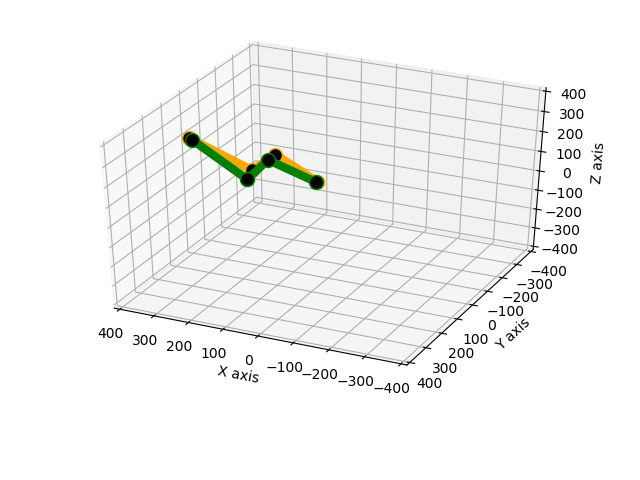

In [197]:
%matplotlib notebook
drawer = Drawer()

o = 18
drawer.draw_robot(pred_pos[o], out[o])